In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:18<00:00, 71.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [2]:
! ls /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data

features_30_sec.csv  features_3_sec.csv  genres_original  images_original


In [44]:
data_path = path + "/Data"

In [45]:
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import sklearn
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [46]:
plt.rcParams['figure.figsize'] = (8, 4)

In [47]:
feature30 = pd.read_csv(data_path + "/features_30_sec.csv")
feature3 = pd.read_csv(data_path + "/features_3_sec.csv")

In [48]:
print("Shape of Features_30sec is ", feature30.shape)
print("Shape of Features_3sec is ", feature3.shape)

Shape of Features_30sec is  (1000, 60)
Shape of Features_3sec is  (9990, 60)


Test Wave form Processing

In [49]:
feature30.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [50]:
# Loading a Sample File
sample_file = data_path + "/genres_original/blues/blues.00020.wav"
signal, sr = librosa.load(sample_file, sr = 22050)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)


y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [51]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


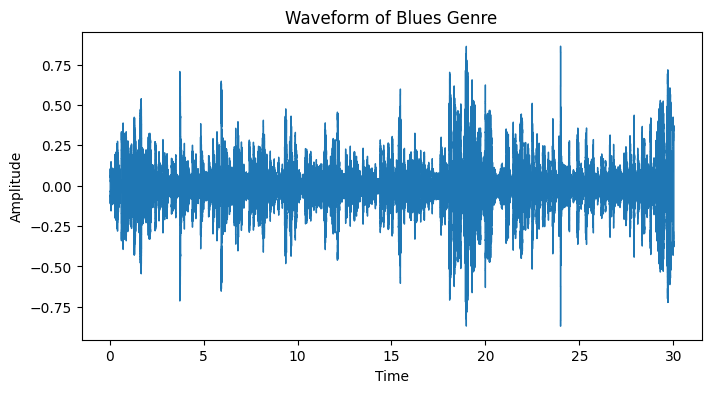

In [52]:
#Waveform
plt.figure(figsize=(8, 4))
librosa.display.waveshow(signal, sr = sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform of Blues Genre")
plt.show()

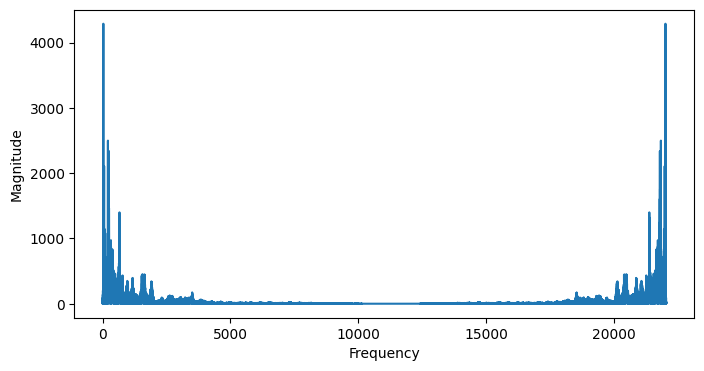

In [53]:
# fft -> spectrum
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
freq = np.linspace(0, sr, len(magnitude)) # linspace gives equally spaced intervals, so basically returns frequency in each sr
plt.figure(figsize=(8, 4))
plt.plot(freq, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

Important part is only the Left half and which is giving us useful information

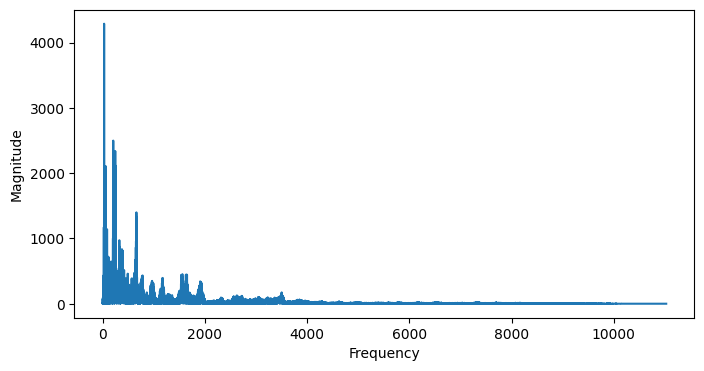

In [54]:
left_magnitude = magnitude[:int(len(magnitude)/2)]
left_freq = freq[:int(len(magnitude)/2)]
plt.figure(figsize=(8, 4))
plt.plot(left_freq, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

Okay so the Only Problem We have with the fft spectogram is, that is giving us a static snapshot of the whole audio file.
but we want to find out how is this frequencies are contirbuting to the overall sound through out whole audio through out time

In [55]:
# stft -> spectrogram

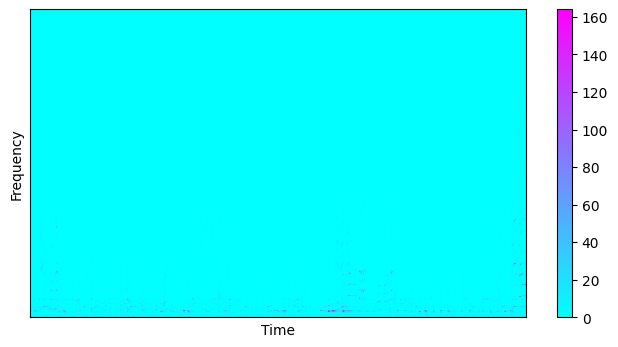

In [56]:
n_fft = 2048 # basially a window we are considering for performing a single Fourier Transform
hop_len = 512 # this is the amount we are shifting to the right, or basically hopping to the right for doing fft
stft = librosa.core.stft(signal, hop_length = hop_len, n_fft = n_fft)
spectrogram = np.abs(stft)

plt.figure(figsize=(8, 4))
librosa.display.specshow(spectrogram, sr = sr, hop_length = hop_len, cmap = 'cool')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

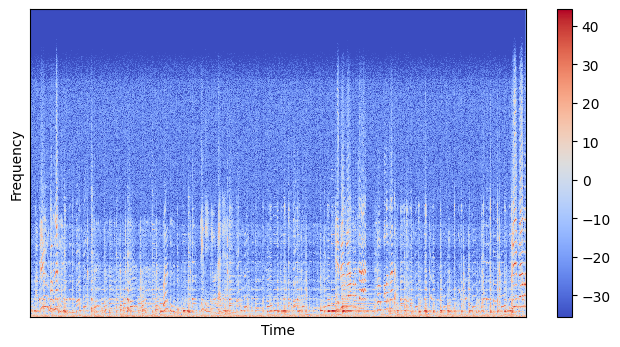

In [57]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(8, 4))
librosa.display.specshow(log_spectrogram, sr = sr, hop_length = hop_len)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

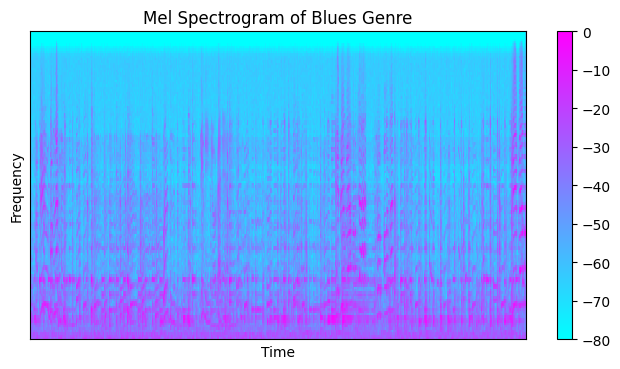

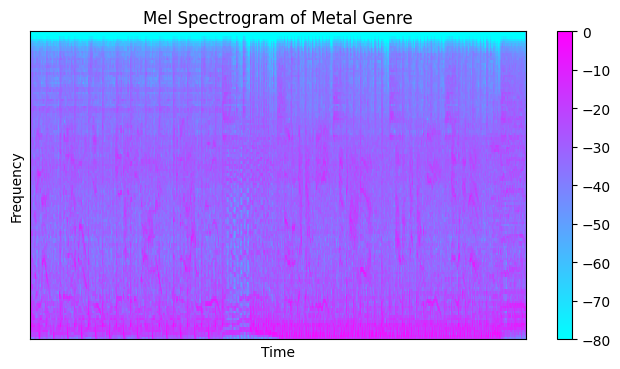

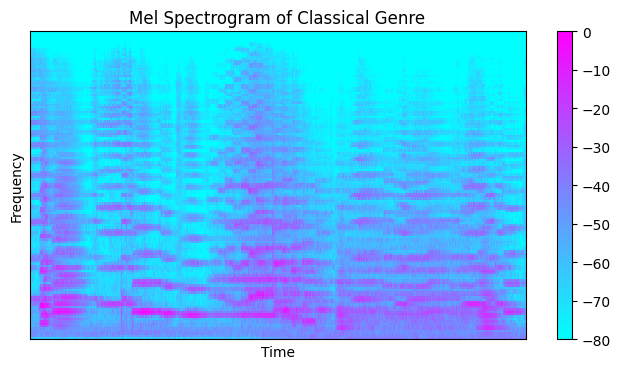

In [58]:
# Mel Spectrogram - blues
s = librosa.feature.melspectrogram(y=signal, sr = sr, n_fft = n_fft, hop_length = hop_len)
s_db = librosa.power_to_db(s, ref = np.max)
librosa.display.specshow(s_db, sr = sr, hop_length = hop_len, cmap='cool')
plt.title('Mel Spectrogram of Blues Genre')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

# Mel Spectrogram For metal genre
y_metal = data_path + "/genres_original/metal/metal.00036.wav"
signal_metal, sr_metal = librosa.load(y_metal, sr = 22050)
s_metal = librosa.feature.melspectrogram(y=signal_metal, sr = sr_metal, n_fft = n_fft, hop_length = hop_len)
s_db_metal = librosa.power_to_db(s_metal, ref = np.max)
librosa.display.specshow(s_db_metal, sr = sr_metal, hop_length = hop_len, cmap='cool')
plt.title('Mel Spectrogram of Metal Genre')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


# Mel Spctrogram for Classical genre
y_classical = data_path + "/genres_original/classical/classical.00036.wav"
signal_classical, sr_classical = librosa.load(y_classical, sr = 22050)
s_classical = librosa.feature.melspectrogram(y=signal_classical, sr = sr_classical, n_fft = n_fft, hop_length = hop_len)
s_db_classical = librosa.power_to_db(s_classical, ref = np.max)
librosa.display.specshow(s_db_classical, sr = sr_classical, hop_length = hop_len, cmap='cool')
plt.title('Mel Spectrogram of Classical Genre')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

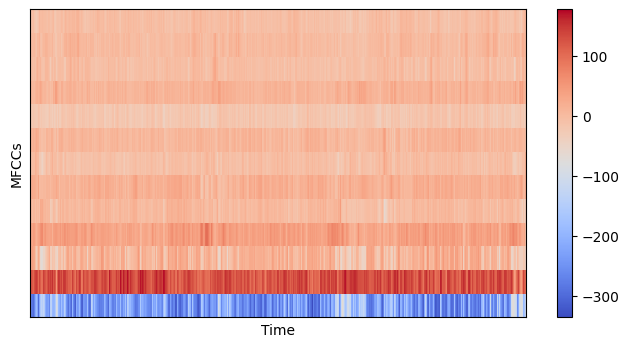

In [59]:
# Now For Mel Frequency Cepstral Coefficient (MFCCs)
MFCCs = librosa.feature.mfcc(y = signal, n_fft = n_fft, hop_length = hop_len, n_mfcc = 13)
# print(MFCCs.shape)
plt.figure(figsize=(8, 4))
librosa.display.specshow(MFCCs, sr = sr, hop_length = hop_len)
plt.xlabel("Time")
plt.ylabel("MFCCs")
plt.colorbar()
plt.show()

Mean: -2.9502685e-09 

Var: 1.0


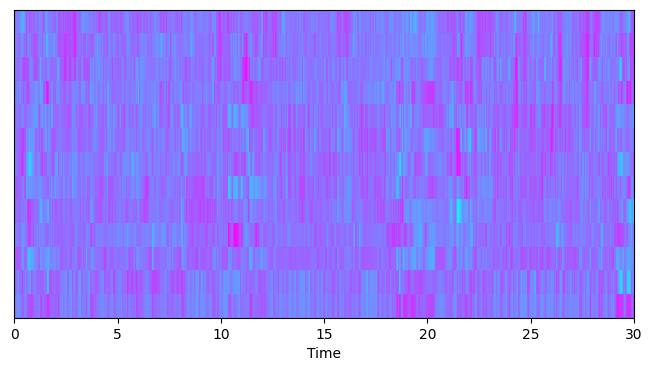

In [60]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(MFCCs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

# plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

Chromogram shape: (12, 1293)


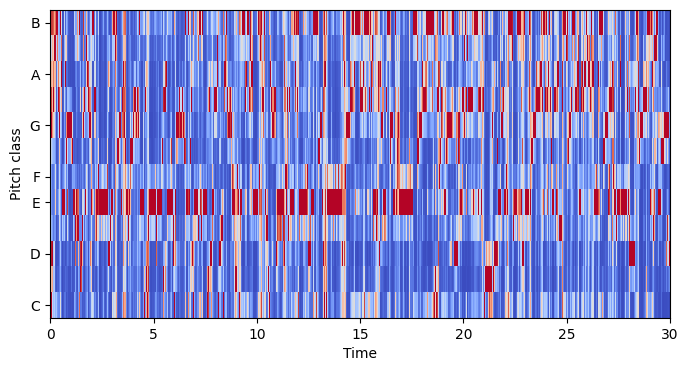

In [61]:
# Chromogram
chromagram = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_len)
print('Chromogram shape:', chromagram.shape)

# plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_len, cmap='coolwarm');